# MODFLOW-API Head monitor example

In this example the modflow-api is used in a more complex callback function to create a Head Monitor that updates at the timestep level. This example reverses `CHD` boundary conditions each stress period on a simple 10 x 10 model and displays the head results for each timestep.


In [1]:
from IPython.display import clear_output, display  # remove this import if adapted to python script

from modflowapi import run_simulation, Callbacks
from modflowapi.util import get_libmf6
from flopy.discretization import StructuredGrid
from flopy.plot import PlotMapView, styles
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Create a class that includes a callback function

This class handles changing the `CHD` boundary condition as well as updating the matplotlib plot.

In [2]:
class StructuredHeadMonitor:
    """
    An example class that reverses the model gradient by
    swapping CHD boundary conditions each stress period, 
    and monitors the head at each timestep by updating
    a matplotlib plot. This class could be adapted to 
    be used as a head monitor to observe other changes
    in the model by modifying the callback class.
    
    Parameters
    ----------
    layer: int
        zero based model layer to plot
    vmin : float
        minimum head value for color scaling on the plot
    vmax : float
        maximum head value for color scaling on the plot
    """

    def __init__(self, layer, vmin, vmax):
        self.modelgrid = None
        self.ax = None
        self.pmv = None
        self.pc = None
        self.ax = None
        self.layer = layer
        self.vmin = vmin
        self.vmax = vmax
        self.kperold = None

    def build_modelgrid(self, ml):
        """
        Method to update the matplotlib plot
        
        Parameters
        ----------
        ml : ApiModel
            modflow-api ApiModel object
        """
        delc = ml.dis.get_advanced_var("delc")
        delr = ml.dis.get_advanced_var("delr")
        top = ml.dis.top.values[0]
        botm = ml.dis.bot.values
        idomain = ml.dis.idomain.values
        self.modelgrid = StructuredGrid(
            delc=delc,
            delr=delr,
            top=top,
            botm=botm,
            idomain=idomain
        )

    def initialize_plot(self):
        """
        Method to initalize a matplotlib plot using flopy
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        self.fig = fig
        self.ax = ax
        self.pmv = PlotMapView(modelgrid=self.modelgrid, ax=ax, layer=self.layer)
        grid = self.pmv.plot_grid()
        idm = self.pmv.plot_inactive()
        initial = np.full(self.modelgrid.shape, np.nan)
        self.pc = self.pmv.plot_array(initial, vmin=self.vmin, vmax=self.vmax)
        plt.colorbar(self.pc)

    def update_plot(self, ml):
        """
        Method to update the matplotlib plot
        
        Parameters
        ----------
        ml : ApiModel
            modflow-api ApiModel object
        """
        heads = ml.X
        self.ax.cla()
        grid = self.pmv.plot_grid()
        idm = self.pmv.plot_inactive()
        self.pc = self.pmv.plot_array(heads, vmin=self.vmin, vmax=self.vmax)
        
        # only applicable to jupyter notebooks, remove these two lines in python scipt
        display(self.fig)  
        if ml.kper == (ml.nper - 1) and ml.kstp == (ml.nstp - 1):
            pass
        else:
            clear_output(wait = True)  
        
        # the pause time can be reduced if adapted in python script 
        plt.pause(0.1)  

    def callback(self, sim, callback_step):
        """
        A demonstration function that dynamically adjusts the CHD
        boundary conditions each stress period in a modflow-6 model
        through the MODFLOW-API and then updates heads on a matplotlib
        plot for each timestep.

        Parameters
        ----------
        sim : modflowapi.Simulation
            A simulation object for the solution group that is 
            currently being solved
        callback_step : enumeration
            modflowapi.Callbacks enumeration object that indicates
            the part of the solution modflow is currently in.
        """
        if callback_step == Callbacks.initialize:
            ml = sim.get_model()
            self.build_modelgrid(ml)
            self.initialize_plot()

        if callback_step == Callbacks.timestep_start:
            ml = sim.get_model()
            if ml.kper == 0:
                self.kperold = ml.kper
                head = ml.chd.stress_period_data.dataframe["head"].values
                self.head = head
            else:
                df = ml.chd.stress_period_data.dataframe
                if self.kperold != ml.kper:
                    self.kperold = ml.kper
                    self.head = self.head[::-1]

                df["head"] = self.head
                ml.chd.stress_period_data.dataframe = df

        if callback_step == Callbacks.timestep_end:
            ml = sim.get_model()
            self.update_plot(ml)


Run the model using the and supply the `StructuredHeadMonitor`'s `callback` function

Solving: Stress Period 12; Timestep 31


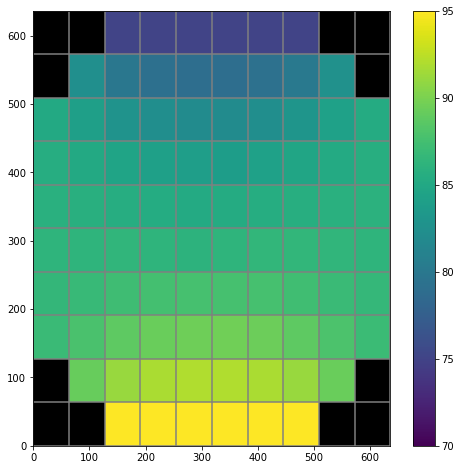

NORMAL TERMINATION OF SIMULATION


In [3]:
hdmon = StructuredHeadMonitor(layer=0, vmin=70, vmax=95)
dll = get_libmf6()
sim_ws = Path("../data/dis_model")
run_simulation(dll, sim_ws, hdmon.callback, verbose=True)